# **Stock Market Prediction**
<ins>Authors:</ins> AIT ALLAOUA Salah, SINAPI Thomas and BAHRI Manitas

The primary goal of this project is to forecast the stock market price of a company. Initially, we aimed to predict the closing price of a day based on the open, high, low, and volume recorded on the same day. However, we encountered challenges in solving this problem, and it appeared to have limited practical utility.

Consequently, we adjusted our approach to focus on predicting the closing price for Friday by considering the cumulative open, high, low, and volume data for the entire week, from Monday to Thursday. This modification is aimed at enhancing the model's ability to capture relevant trends and patterns for more accurate predictions.

In [1]:
# Includes libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## <ins>**Utils Functions**</ins>
Definition of functions to be used for the pre-processing part.

In [2]:
def find_weeks(dataframe):
    """
    Find the successive rows which are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    keys = ["Date"] + dataframe.columns.tolist()
    week = []
    
    # Create a dataframe to store the weekly data
    df_cycle = pd.DataFrame()

    # Iterate through the dataframe
    for i_date, i_values in dataframe.iterrows():
        # Check if current date is monday
        is_monday = i_date.weekday() == 0
        
        # Check if current date is friday and the data_week contains previous 4 days
        is_friday = len(week) == 4 and i_date.weekday() == 4

        # Check if the date is next day of the last date in data_week
        is_next_day = len(week) != 0 and week[-1][0] + datetime.timedelta(days=1) == i_date

        # Fill the week list with i_values
        if is_monday or is_friday or is_next_day:
            week = [] if is_monday else week
            week += [[i_date] + i_values.values.tolist()]

        # If the week contains 5 days, add it to the dataframe
        if len(week) == 5:
            df_week = pd.DataFrame(week, columns=keys)
            df_cycle = pd.concat([df_cycle, df_week], axis=0)
            week = []

    return df_cycle


def group_weeks(dataframe):
    """
    Concatenate the rows that are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    df_cyclic = dataframe.drop(columns=["Company", "Date"])
    df_weeks = pd.DataFrame()

    # Create column names containing the week number
    columns = []

    for j in range(5):
        for i in range(df_cyclic.shape[1]):
            columns += [df_cyclic.columns[i] + "_" + str(j)]

    # Iterate every 5 rows to create a dataframe for each week
    for i in range(0, len(df_cyclic), 5):
        # Create a series containing the week data
        week = np.append(df_cyclic[i:i+5].values, dataframe["Company"].iloc[i]).reshape(1, -1)
        week = np.insert(week, 0, dataframe["Date"].iloc[i].date(), axis=1)
        week = pd.DataFrame(week)

        # Add the week series to the weeks dataframe
        df_weeks = pd.concat([df_weeks, week], axis=0)

    df_weeks.columns = ["Date"] + columns + ["Company"]

    return df_weeks.reset_index(drop=True)

## <ins>**I. Data Preprocessing**</ins>

### A. Data Collection
Create a dataframe that includes the open, high, low, close prices, and volumes for a specified company, covering Monday through Friday of a given week.

In [38]:
# Set the path to the data
path = "data/"

# Write data into a dataframe
dataframe = pd.DataFrame()

for file in os.listdir(path):
    df_read = pd.read_csv(path + file, sep = ",")
    df_read["Company"] = file.split("(")[0]
    df_read["Date"] = pd.to_datetime(df_read["Date"])
    df_read.set_index("Date", inplace=True)
    df_read = find_weeks(df_read)
    df_read = group_weeks(df_read)

    dataframe = pd.concat([dataframe, df_read], axis=0)

# Set the date as the index
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)

# Convert the columns to numeric except the 'Company' column
numeric_columns = dataframe.columns[dataframe.columns != "Company"]
dataframe[numeric_columns] = dataframe[numeric_columns].astype(float)

# Save the dataframe as a csv file
# dataframe.to_csv("weekly_data.csv")

dataframe.head()

,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4,Company
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,9.276582,10.405363,9.229810,9.853446,9.853446,3727496.0,9.834737,10.380418,9.747428,10.015591,...,10.074836,10.074836,856590.0,10.046773,10.121609,9.909573,10.093545,10.093545,580788.0,ZG
2013-01-14,10.215154,10.361709,10.043655,10.302463,10.302463,873266.0,10.289991,10.477081,10.212036,10.352354,...,10.071718,10.071718,805919.0,10.043655,10.439663,10.006236,10.355472,10.355472,867494.0,ZG
2013-01-28,11.088244,11.764889,10.994699,11.615217,11.615217,1932538.0,11.506080,11.506080,10.760836,10.826317,...,11.799189,11.799189,1123733.0,11.842844,11.842844,11.328344,11.537262,11.537262,1014374.0,ZG
2013-02-04,11.175553,11.506080,11.069535,11.481135,11.481135,634665.0,11.527908,11.849080,11.465544,11.827253,...,11.446835,11.446835,648135.0,11.490490,11.499844,11.166199,11.200499,11.200499,1337960.0,ZG
2013-02-11,11.259744,11.406299,11.163081,11.318990,11.318990,1192042.0,11.381353,11.640162,11.200499,11.272217,...,13.189897,13.189897,14261529.0,13.252261,14.150296,13.037106,14.009978,14.009978,5422396.0,ZG


In [2]:
# Load the dataframes already saved
dataframe = pd.read_csv("weekly_data.csv")

Analyse the statistical properties of the data, and check for missing values.

In [3]:
print(f"Total number of missing values: {dataframe.isnull().sum().sum()}")
dataframe.drop(["Company"], axis=1).describe()

Total number of missing values: 0


,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Low_3,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4
count,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,...,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04
mean,78.055401,79.059313,77.050397,78.115126,74.813691,3.173252e+07,78.235989,79.183661,77.219097,78.203377,...,77.202958,78.216668,74.921602,3.285176e+07,78.253644,79.144698,77.190071,78.179601,74.885862,3.438584e+07
std,75.587629,76.675148,74.488578,75.710433,75.987190,4.856106e+07,75.815509,76.824855,74.727377,75.794895,...,74.674221,75.711573,75.989412,4.828235e+07,75.734394,76.635671,74.578126,75.610566,75.886549,5.108344e+07
min,1.670000,1.700000,1.610000,1.620000,1.620000,1.436000e+05,1.620000,1.690000,1.620000,1.660000,...,1.660000,1.700000,1.700000,1.749000e+05,1.680000,1.750000,1.650000,1.670000,1.670000,1.341000e+05
25%,28.345625,28.641996,27.967681,28.287501,25.007929,6.118600e+06,28.306545,28.663370,27.990702,28.326427,...,28.035520,28.360001,25.078379,6.430675e+06,28.375872,28.700001,28.064085,28.382764,25.148379,6.529200e+06
50%,52.860001,53.563001,52.180000,52.904999,49.470890,1.681095e+07,52.980000,53.681249,52.207175,53.003750,...,52.270000,53.070000,49.698305,1.748610e+07,53.014999,53.664999,52.392876,53.013001,49.631620,1.810615e+07
75%,101.884998,103.000000,100.560001,101.612501,97.653346,3.699230e+07,102.000000,103.099998,100.802502,101.929998,...,101.042502,102.232502,98.006184,3.876410e+07,102.121876,103.270998,101.029999,102.130003,97.904793,4.079450e+07
max,689.059998,689.969971,676.539978,681.169983,681.169983,7.855176e+08,683.109985,688.359985,676.900024,687.400024,...,679.739990,682.020020,682.020020,7.599116e+08,692.349976,694.159973,675.000000,690.309998,690.309998,7.640976e+08


### B. Data Transformation and Normalization
Encode the column `Company` using one-hot encoding to create a new column for each company, with a value of 1 if the row corresponds to that company, and 0 otherwise.

In [4]:
# Label encode the company column
encoder = OneHotEncoder(handle_unknown="error")
company_encoded = encoder.fit_transform(dataframe[["Company"]]).toarray()
df_company_encoded = pd.DataFrame(company_encoded, columns=encoder.get_feature_names_out())

dataframe_enc = pd.concat([dataframe, df_company_encoded], axis=1)
dataframe_enc.drop(["Company"], axis=1, inplace=True)

dataframe_enc.head()

,Date,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,...,Company_NVDA,Company_PFE,Company_PYPL,Company_T,Company_TSLA,Company_TTD,Company_WMT,Company_XOM,Company_YELP,Company_ZG
0,2013-01-07,13.266705,13.386636,12.938321,13.143918,11.812600,5607402.0,13.212450,13.375214,12.941176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-14,12.412907,12.418618,12.238721,12.412907,11.155633,3008568.0,12.364363,12.412907,12.075957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-28,11.553398,11.793261,11.507710,11.616219,10.439638,4930116.0,11.659052,11.687607,11.427756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-04,11.747573,11.881782,11.681896,11.753284,10.562821,3747840.0,11.821816,12.247287,11.810394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-11,12.541405,12.561393,12.361508,12.421473,11.163330,7001198.0,12.361508,12.378641,12.107367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Select the columns that will be used as features to predict the closing price. The column `Close_4` will be used as the target variable.

Then, split the data into a train (~70%), validation (~20%) and test set (~10%).

In [5]:
# Select the features and the target
X = dataframe_enc.drop(["Date", "Open_4", "High_4", "Low_4", "Close_4", "Adj Close_4", "Volume_4"], axis=1)
X = X.drop([f for f in X.columns if f.startswith("Adj")], axis=1)
y = dataframe_enc["Close_4"]

# Split the data into train, test and validation sets.
# Train set: 70%, Validation set: ~20%, Test set: ~10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3)

print(f"TRAIN SIZE: {X_train.shape[0], y_train.shape[0]} -> {X_train.shape[0] / X.shape[0] * 100:.2f}%")
print(f"VAL   SIZE: {X_val.shape[0], y_val.shape[0]} -> {X_val.shape[0] / X.shape[0] * 100:.2f}%")
print(f"TEST  SIZE: {X_test.shape[0], y_test.shape[0]} -> {X_test.shape[0] / X.shape[0] * 100:.2f}%")

TRAIN SIZE: (8803, 8803) -> 70.00%
VAL   SIZE: (2515, 2515) -> 20.00%
TEST  SIZE: (1258, 1258) -> 10.00%


Standardize the data using the mean and standard deviation of the training set, and apply the same transformation to the validation and test sets.

In [6]:
# Standardize the features
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

# Standardize the target
scaler_y = StandardScaler()
y_train_ss = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_ss = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
y_test_ss = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

### C. Pricinpal Component Analysis
Apply PCA and evaluate the explained variance of each principal component to determine the optimal number of components to retain.

The number of principal components is: 50


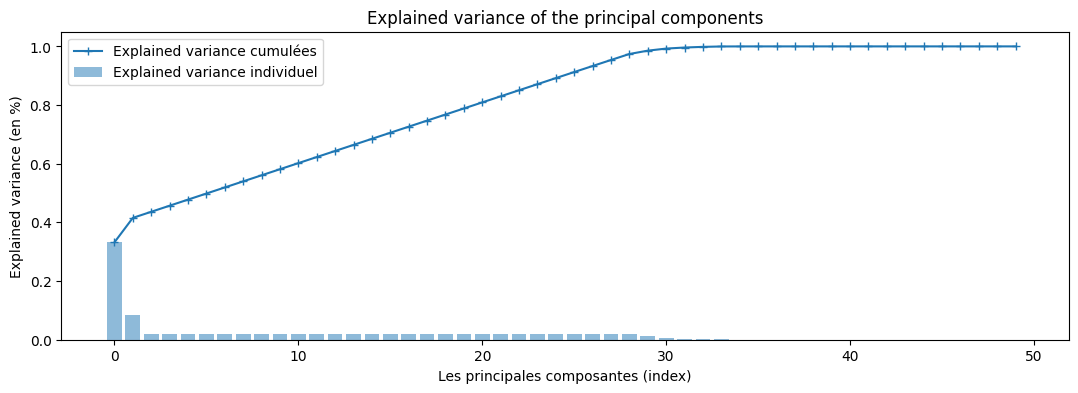

In [7]:
# Application of the PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
print(f"The number of principal components is: {pca.n_components_}")

# Visualization of the explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_

plt.figure(figsize=(13, 4))
plt.bar(range(len(exp_var_pca)), height=exp_var_pca, label="Explained variance individuel", alpha=.5)
plt.plot(np.cumsum(exp_var_pca), marker="+", label="Explained variance cumulées")
plt.xlabel("Les principales composantes (index)")
plt.ylabel("Explained variance (en %)")
plt.title("Explained variance of the principal components")
plt.legend()
plt.show()

After analysing the above graph, we can see that the best n_components is 29, because after that the explained variance is almost constant.

In [8]:
# Application of the PCA with 29 components
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

## <ins>**II. Data Visualization**</ins>

### A. Stock Prices Evolution
The following graph shows the evolution of the closing price of GAFAM companies from 2013 to 2022. As can be seen, the share prices of these companies have risen in the same way over the years. It seems that the share prices of these companies are correlated.

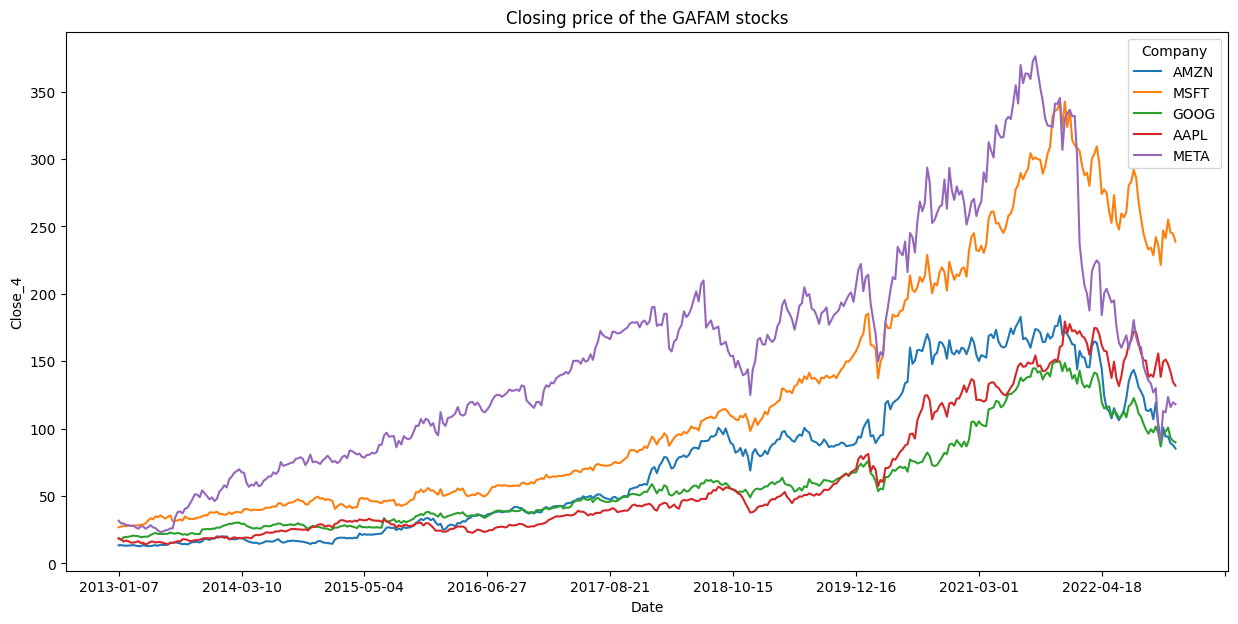

In [9]:
GAFAM = ["GOOG", "AMZN", "META", "AAPL", "MSFT"]
GAFAM = dataframe[dataframe["Company"].isin(GAFAM)]

# Plot the closing price of the GAFAM stocks
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x="Date", y="Close_4", hue="Company", data=GAFAM)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.title("Closing price of the GAFAM stocks")
plt.show()

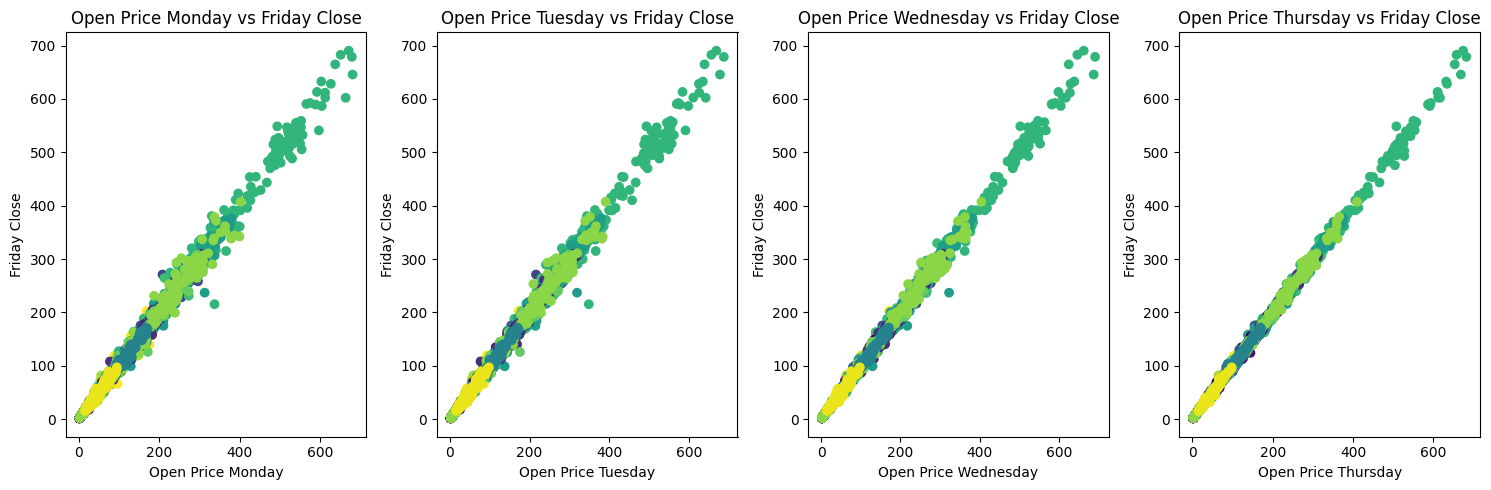

In [10]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
ax = plt.figure(figsize=(15, 5))

# Label encode the company column
enc = LabelEncoder()
c = enc.fit_transform(dataframe["Company"])

for i in range(0, 4):
    ax = plt.subplot(1, 4, i+1)
    plt.scatter(dataframe[f"Close_{i}"], dataframe["Close_4"], c=c)
    plt.xlabel(f"Open Price {days[i]}")
    plt.ylabel("Friday Close")
    plt.title(f"Open Price {days[i]} vs Friday Close")

plt.tight_layout()
plt.show()

The presented graphs illustrate the correlation between the closing price of each day and the closing price on Friday. It is evident from the graphs that the correlation is notably high, indicating that the closing price of a given day closely aligns with the closing price on Friday of the same week. This observation aligns with real-life scenarios, where, barring exceptional events, the closing price tends to remain relatively consistent throughout the week.

### B. PCA Visualization

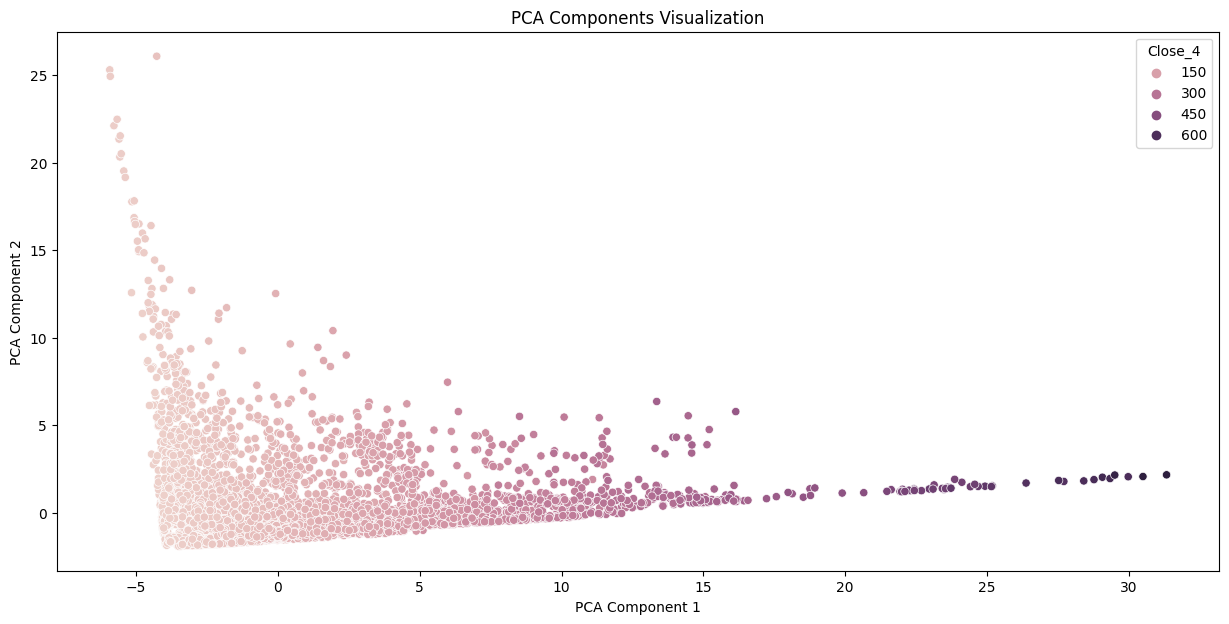

In [11]:
# PCA Components Visualization
plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA Components Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

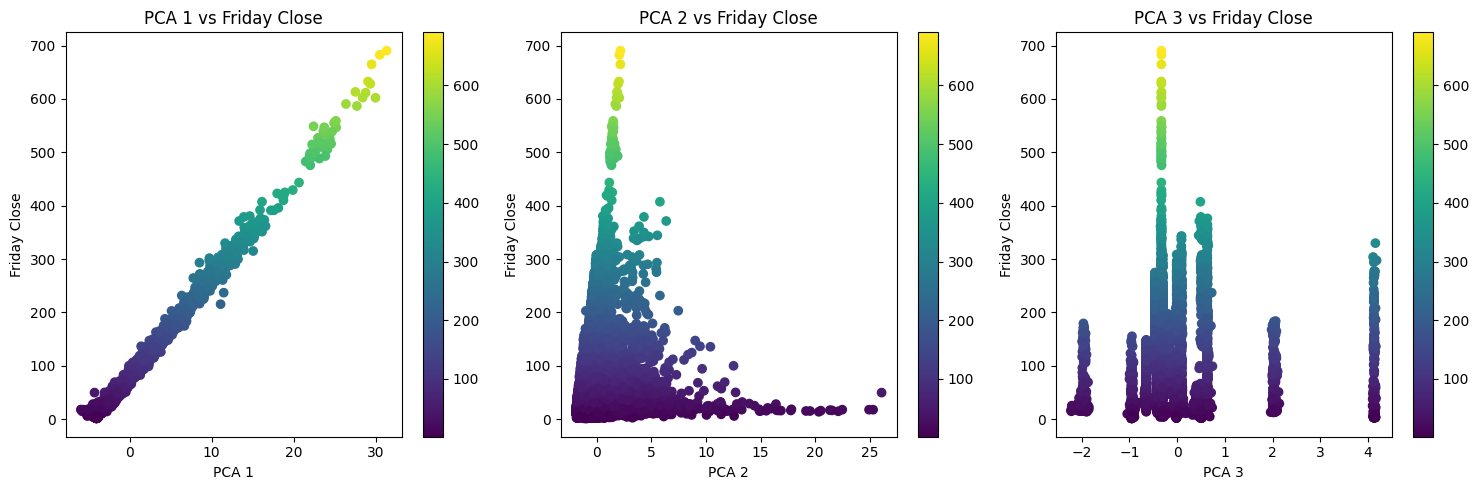

In [12]:
ax = plt.figure(figsize=(15, 5))

# Plot the PCA components vs the friday closing price
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.scatter(X_train_pca[:, i], y_train, c=y_train)
    plt.xlabel("PCA " + str(i+1))
    plt.ylabel("Friday Close")
    plt.title("PCA " + str(i+1) + " vs Friday Close")
    plt.colorbar()

plt.tight_layout()
plt.show()

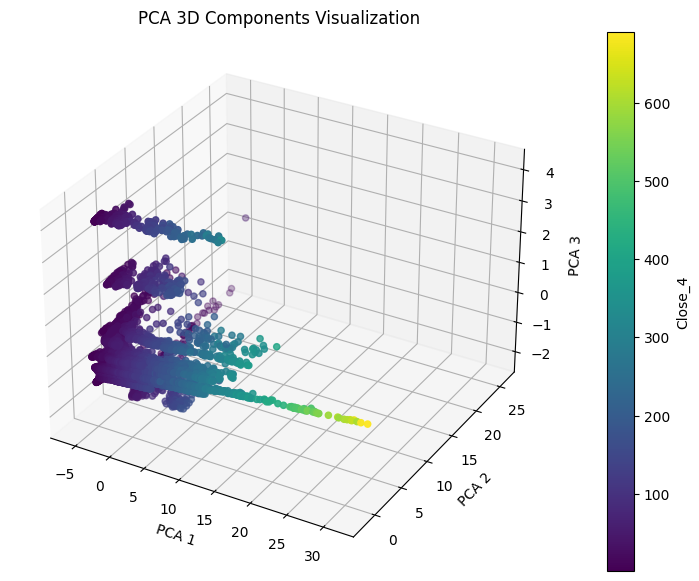

In [13]:
# PCA 3D Components Visualization
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, label="Close_4")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
cbar = plt.colorbar(scatter)
cbar.set_label("Close_4")
plt.title("PCA 3D Components Visualization")
plt.show()

### C. Data Distribution

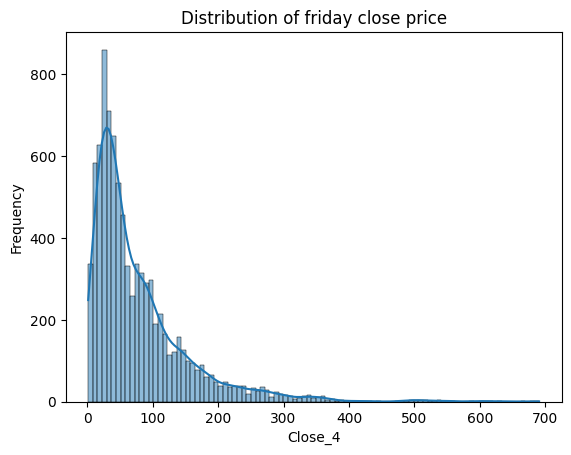

In [14]:
# Plot the distribution of the friday closing price
sns.histplot(y_train, kde=True)
plt.title('Distribution of friday close price')
plt.ylabel('Friday Close')
plt.ylabel('Frequency')
plt.show()

## <ins>**III. Building the Model**</ins>

### A. Model Selection
In this section, we test different regression models to find the one best suited to our problem.

In [15]:
# Test different models to find the best one
for model in [LinearRegression, BayesianRidge, SVR, RandomForestRegressor]:
    scores = cross_val_score(model(), X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    print(f"{model.__name__} MSE: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

LinearRegression MSE: 5.6699 (+/- 1.2335)
BayesianRidge MSE: 5.6522 (+/- 1.2429)
SVR MSE: 1110.8535 (+/- 521.4747)
RandomForestRegressor MSE: 7.2523 (+/- 1.3135)


### B. Optimization of Hyperparameters

We chose the Random Forest model for its superior performance. Additionally, this model provides numerous hyperparameters that can be fine-tuned to further enhance its effectiveness.
Consequently, we will assess the model's performance by testing variations, such as employing PCA or not, and scaling the target variable or not.

In [16]:
print("With PCA")
print("Comparing the MSE for the scaled and unscaled data")

# Train the model with output not scaled
reg = RandomForestRegressor()
reg.fit(X_train_pca, y_train)

y_pred_train = reg.predict(X_train_pca)
y_pred_val = reg.predict(X_val_pca)

print(f"MSE Train                : {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MSE Validation           : {mean_squared_error(y_val, y_pred_val):.4f}")

# Train the model with output scaled
reg_scaled = RandomForestRegressor()
reg_scaled.fit(X_train_pca, y_train_ss)

y_pred_train = scaler_y.inverse_transform(reg_scaled.predict(X_train_pca).reshape(-1, 1))
y_pred_val = scaler_y.inverse_transform(reg_scaled.predict(X_val_pca).reshape(-1, 1))

print(f"MSE Train      (ŷ scaled): {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MSE Validation (ŷ scaled): {mean_squared_error(y_val, y_pred_val):.4f}\n")

With PCA
Comparing the MSE for the scaled and unscaled data
MSE Train                : 2.3902
MSE Validation           : 14.1997
MSE Train      (ŷ scaled): 2.3382
MSE Validation (ŷ scaled): 14.2868



In [17]:
print("Without PCA")
print("Comparing the MSE for the scaled and unscaled data")

# Train the model with output not scaled
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)

print(f"MSE Train                : {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MSE Validation           : {mean_squared_error(y_val, y_pred_val):.4f}")

# Train the model with output scaled
reg_scaled = RandomForestRegressor()
reg_scaled.fit(X_train, y_train_ss)

y_pred_train = scaler_y.inverse_transform(reg_scaled.predict(X_train).reshape(-1, 1))
y_pred_val = scaler_y.inverse_transform(reg_scaled.predict(X_val).reshape(-1, 1))

print(f"MSE Train      (ŷ scaled): {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MSE Validation (ŷ scaled): {mean_squared_error(y_val, y_pred_val):.4f}\n")

Without PCA
Comparing the MSE for the scaled and unscaled data
MSE Train                : 1.0168
MSE Validation           : 7.2987
MSE Train      (ŷ scaled): 0.9847
MSE Validation (ŷ scaled): 7.7348



It can be observed that the model demonstrates superior performance when PCA is not utilized and the target variable is left unscaled. The random forest regressor, being a model built on decision trees, exhibits insensitivity to the scaling of the target variable.

### C. Optimization of Model Parameters

In [7]:
# Find the best criterion for our problem
for criterion in ["squared_error", "absolute_error", "friedman_mse", "poisson"]:
    reg = RandomForestRegressor(criterion=criterion)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)

    print(f"{criterion}")
    print(f"MSE Train      : {mean_squared_error(y_train, y_pred_train):.4f}")
    print(f"MSE Validation : {mean_squared_error(y_val, y_pred_val):.4f}\n")


squared_error
MSE Train      : 1.0319
MSE Validation : 6.4893

absolute_error
MSE Train      : 1.0272
MSE Validation : 6.1818

friedman_mse
MSE Train      : 1.0378
MSE Validation : 6.5435

poisson
MSE Train      : 1.0472
MSE Validation : 6.4155



It is noticeable that the criterion has negligible influence on the model's performance.

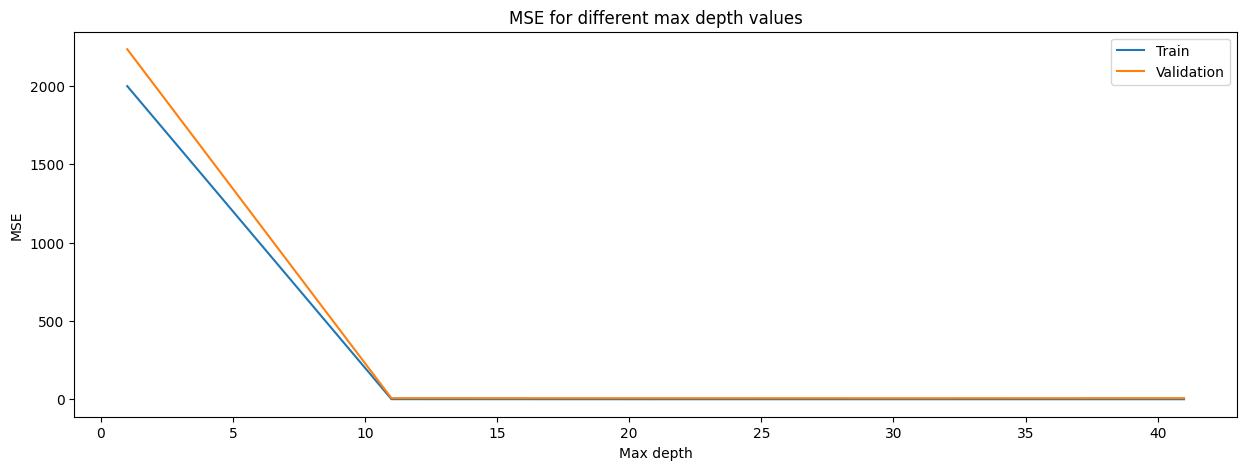

In [18]:
# Optimization of max_depth parameter
depths = np.arange(1, 50, 10)
mse_train, mse_val = [], []

# Train the model with different max_depth values
for depth in depths:
    reg = RandomForestRegressor(max_depth=depth)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)

    mse_train += [mean_squared_error(y_train, y_pred_train)]
    mse_val += [mean_squared_error(y_val, y_pred_val)]

# Plot the MSE for the train and validation sets
plt.figure(figsize=(15, 5))
plt.plot(depths, mse_train, label="Train")
plt.plot(depths, mse_val, label="Validation")
plt.xlabel("Max depth")
plt.ylabel("MSE")
plt.title("MSE for different max depth values")
plt.legend()
plt.show()

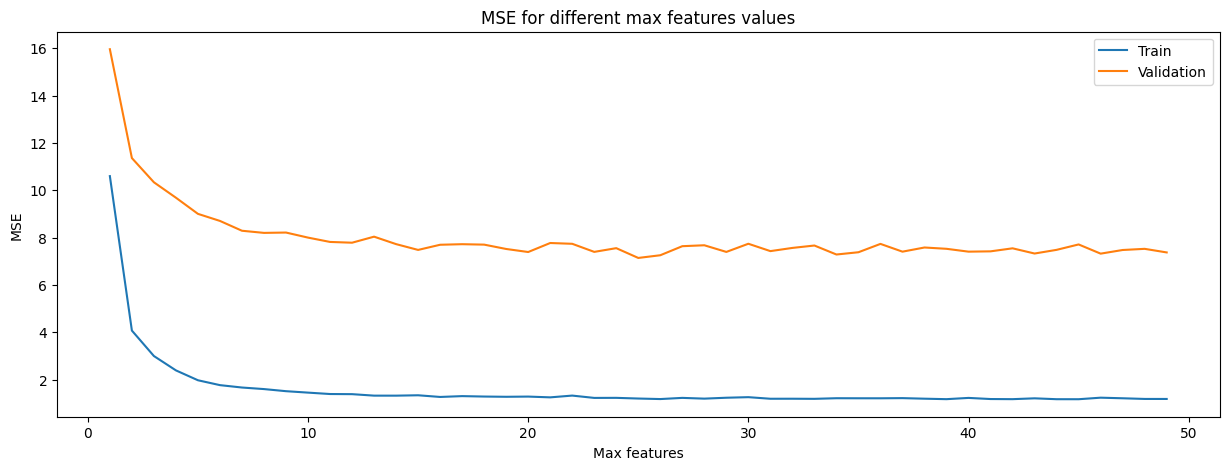

In [19]:
# Optimization of max_features parameter
features = np.arange(1, X_train.shape[1], 1)
mse_train, mse_val = [], []

# Train the model with different max_features values
for feature in features:
    reg = RandomForestRegressor(max_depth=12, max_features=feature)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)

    mse_train += [mean_squared_error(y_train, y_pred_train)]
    mse_val += [mean_squared_error(y_val, y_pred_val)]

# Plot the MSE for the train and validation sets
plt.figure(figsize=(15, 5))
plt.plot(features, mse_train, label="Train")
plt.plot(features, mse_val, label="Validation")
plt.xlabel("Max features")
plt.ylabel("MSE")
plt.title("MSE for different max features values")
plt.legend()
plt.show()

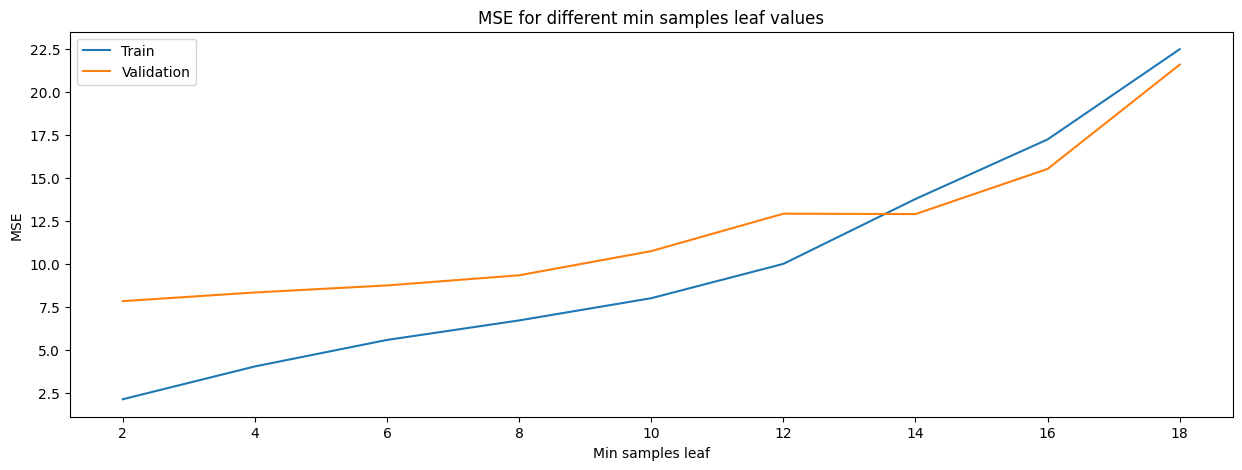

In [20]:
# Optimization of min_samples_leaf parameter
min_samples_leaf = np.arange(2, 20, 2)
mse_train, mse_val = [], []

# Train the model with different min_samples_leaf values
for samples_leaf in min_samples_leaf:
    reg = RandomForestRegressor(max_depth=12, max_features=10, min_samples_leaf=samples_leaf)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)

    mse_train += [mean_squared_error(y_train, y_pred_train)]
    mse_val += [mean_squared_error(y_val, y_pred_val)]

# Plot the MSE for the train and validation sets
plt.figure(figsize=(15, 5))
plt.plot(min_samples_leaf, mse_train, label="Train")
plt.plot(min_samples_leaf, mse_val, label="Validation")
plt.xlabel("Min samples leaf")
plt.ylabel("MSE")
plt.title("MSE for different min samples leaf values")
plt.legend()
plt.show()

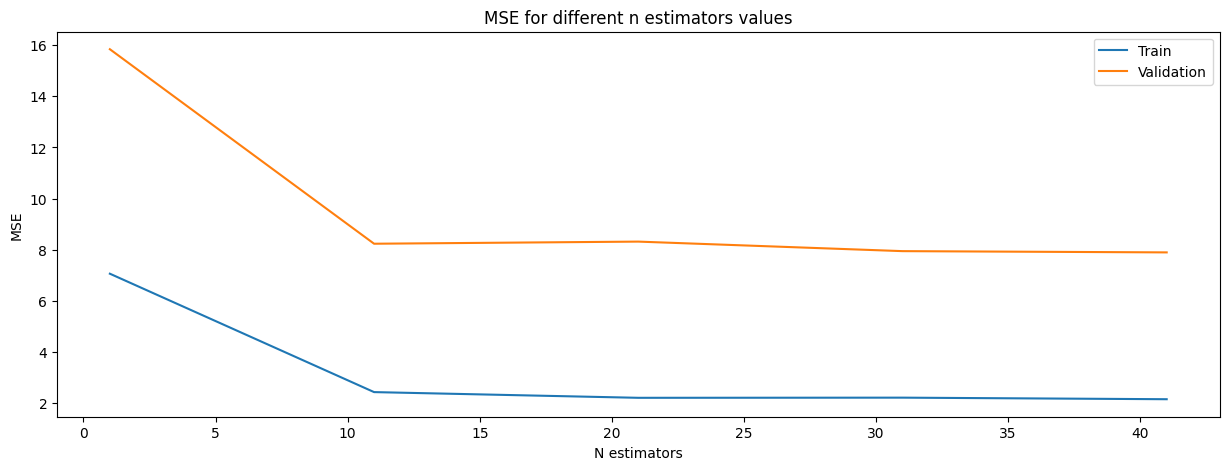

In [21]:
# Optimization of n_estimators parameter
estimators = np.arange(1, 50, 10)
mse_train, mse_val = [], []

# Train the model with different n_estimators values
for estimator in estimators:
    reg = RandomForestRegressor(max_depth=12, max_features=10, min_samples_leaf=2, n_estimators=estimator)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_val = reg.predict(X_val)

    mse_train += [mean_squared_error(y_train, y_pred_train)]
    mse_val += [mean_squared_error(y_val, y_pred_val)]

# Plot the MSE for the train and validation sets
plt.figure(figsize=(15, 5))
plt.plot(estimators, mse_train, label="Train")
plt.plot(estimators, mse_val, label="Validation")
plt.xlabel("N estimators")
plt.ylabel("MSE")
plt.title("MSE for different n estimators values")
plt.legend()
plt.show()

### D. Model Training and Evaluation

We can train the model using the optimal parameters obtained in the previous section.

In [46]:
# Set the model with the best parameters
reg = RandomForestRegressor(max_depth=12, max_features=10, min_samples_leaf=2, n_estimators=12)
reg.fit(X_train, y_train)

# Predict the output
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)

print("Model Evaluation with Best Params")
print(f"MSE TRAIN: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MSE VAL  : {mean_squared_error(y_val, y_pred_val):.4f}\n")
print(f"MAE TRAIN: {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"MAE VAL  : {mean_absolute_error(y_val, y_pred_val):.4f}\n")
print(f"R2  TRAIN: {r2_score(y_train, y_pred_train)}")
print(f"R2  VAL  : {r2_score(y_val, y_pred_val)}")

Model Evaluation with Best Params
MSE TRAIN: 2.6287
MSE VAL  : 8.4658

MAE TRAIN: 0.7863
MAE VAL  : 1.3271

R2  TRAIN: 0.9995439771811278
R2  VAL  : 0.9985443994070532


With the code below, we assess whether the stock market price increases or decreases from Thursday to Friday. We then compare this observed trend with the predictions made by our model to determine if the model accurately forecasts the direction of the trend.

In [47]:
# Get the thuersday closing price of the validation set
close_3 = scaler_x.inverse_transform(X_val)[:, 18]

# Compute the profit with the predicted and real closing price
profit_pred = y_pred_val - close_3
profit_real = y_val - close_3
correct_trend = (profit_pred * profit_real) >= 0

print(f"{correct_trend.sum() / len(correct_trend) * 100:.2f}% of the predictions have the same trend as the real data")

52.21% of the predictions have the same trend as the real data


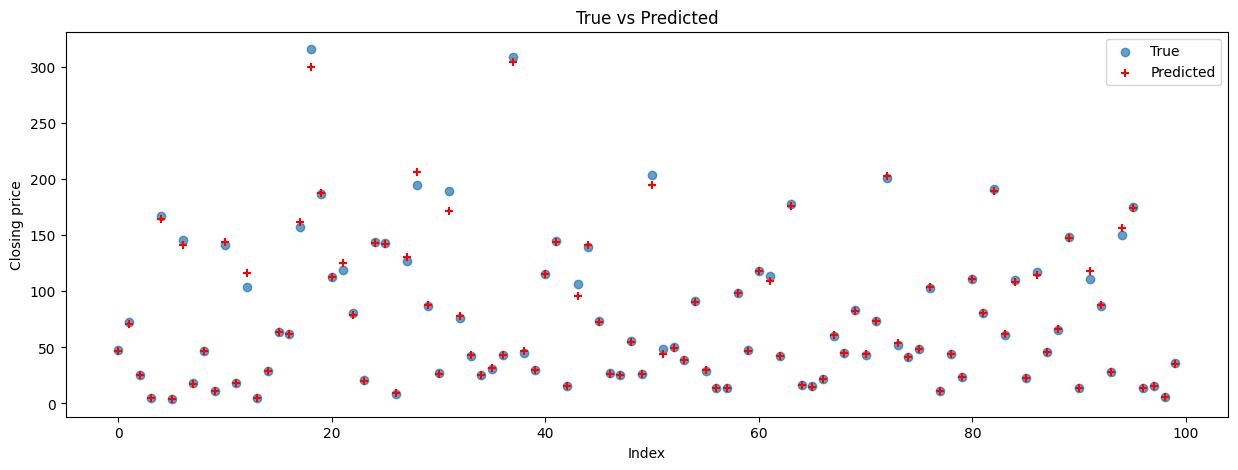

In [48]:
# Plot the true and predicted closing price
ids = range(100)
rand_ids = np.random.randint(0, len(X_val), size=len(ids))

plt.figure(figsize=(15, 5))
plt.scatter(x=ids, y=y_val.values[rand_ids], label="True", alpha=.7)
plt.scatter(x=ids, y=y_pred_val[rand_ids], label="Predicted", alpha=1, marker="+", c="red")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()

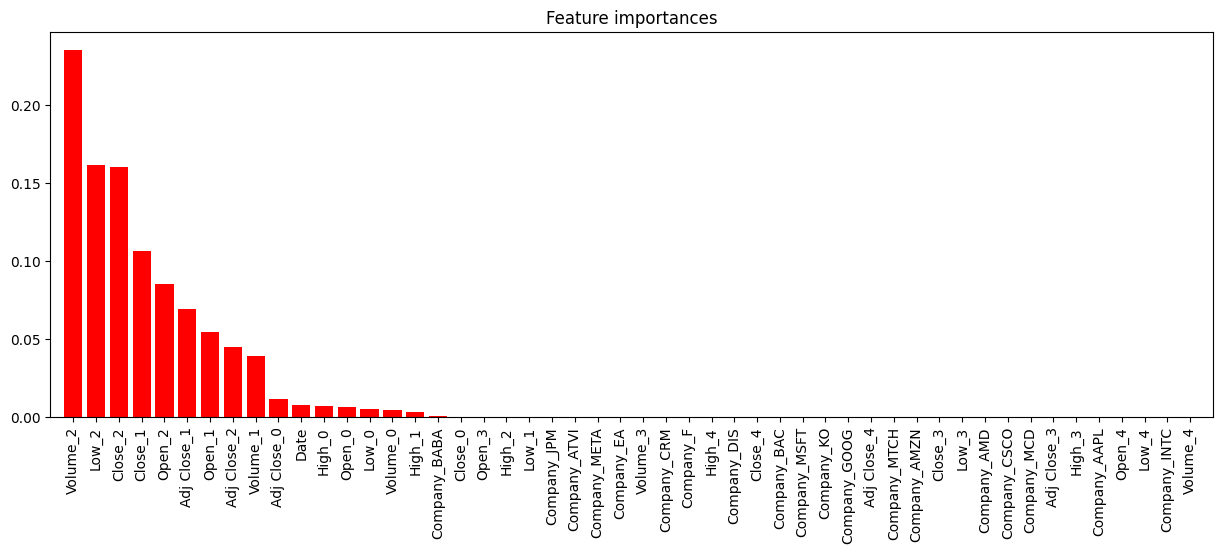

In [25]:
# Plot the feature importances
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), dataframe_enc.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


## <ins>**III. Comparison with Statistical Dataset**</ins>

In this section, we aim to create a dataset comprising statistical data for the entire week and subsequently contrast it with predictions made by our earlier model. This approach is motivated by our analysis, which indicates that our model heavily relies on Thursday's data to forecast Friday's stock price.

### A. Data Collection and Preprocessing

It the same preprocessing steps as in the first section.

In [26]:
# Create a dataframe containing the statistics of the data
df_statistics = pd.DataFrame()

# Get the features names for each day
features = [f"{prefix}_{i}" for prefix in ["Low", "Open", "High", "Close"] for i in range(5)]
# Get the features names for thursday
thursday = [f for f in features if f.endswith("3")]
# Get the volume features names for each day
volume = [f"Volume_{i}" for i in range(5)]

# Compute the statistics for each day
df_statistics["Mean"] = dataframe[features].mean(axis=1)
df_statistics["Std"] = dataframe[features].std(axis=1)
df_statistics["Median"] = dataframe[features].median(axis=1)
df_statistics["Range"] = dataframe[features].max(axis=1) - dataframe[features].min(axis=1)

# Compute the statistics for the volume
df_statistics["Volume"] = dataframe[volume].mean(axis=1)

# Set the thuersday data
df_statistics[thursday] = dataframe[thursday]

# Set the target
df_statistics["Close"] = dataframe["Close_4"]

df_statistics.head()

,Mean,Std,Median,Range,Volume,Low_3,Open_3,High_3,Close_3,Close
0,12.872501,0.386993,12.984009,1.170759,5230237.0,12.215877,13.029697,13.058252,12.327242,12.390063
1,12.151342,0.192196,12.178755,0.576813,4743669.2,11.910337,12.178755,12.178755,11.944603,11.910337
2,11.692319,0.144450,11.684752,0.542547,4460427.4,11.587664,11.613364,11.896059,11.778983,11.867504
3,12.172473,0.340312,12.175899,1.087950,8698267.6,12.347230,12.441462,12.769846,12.527127,12.484295
4,12.148344,0.234347,12.135922,0.793832,6783864.2,11.856082,12.110223,12.130211,11.870360,11.907481


In [27]:
# Select the features and the target
X_stat = df_statistics.drop(["Close"], axis=1)
y_stat = df_statistics["Close"]

# Split the data into train, test and validation sets.
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.3, shuffle=True)

# Get the thuersday closing price of the validation set
close_3 = X_test_stat["Close_3"].values

# Remove the thuersday data
X_train_stat = X_train_stat.drop(thursday, axis=1)
X_test_stat = X_test_stat.drop(thursday, axis=1)

# Standardize the data
scaler_x_stat = StandardScaler()
X_train_stat = scaler_x_stat.fit_transform(X_train_stat)
X_test_stat = scaler_x_stat.transform(X_test_stat)

### B. Optimization of Model Parameters

In [34]:
# Define the grid of parameters to test
param_grid = {
    'max_depth': depths,
    'max_features': np.arange(1, X_train_stat.shape[1], 1),
    'min_samples_leaf': min_samples_leaf,
    'n_estimators': estimators,
}

# Search for the best parameters
gs = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid, cv=5, verbose=3, scoring="neg_mean_squared_error", n_iter=2000)
gs.fit(X_train_stat, y_train_stat)

print(f"Best parameters: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

/home/manitas/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 900 is smaller than n_iter=2000. Running 900 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=1;, score=-5511.400 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=1;, score=-1766.903 total time=   0.0s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=1;, score=-2056.247 total time=   0.0s
[CV 4/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=1;, score=-5299.600 total time=   0.0s
[CV 5/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=1;, score=-3976.118 total time=   0.0s
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=11;, score=-2344.823 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=11;, score=-2052.703 total time=   0.1s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=2, n_estimators=11;, score=-2090.427 total time=   0.0s
[CV 4/5] END max_dept

### D. Model Training and Evaluation

In [35]:
# Train the model with the best parameters
reg = RandomForestRegressor(max_depth=21, max_features=4, min_samples_leaf=2, n_estimators=31)
reg.fit(X_train_stat, y_train_stat)

# Predict the output
y_pred_train = reg.predict(X_train_stat)
y_pred_test = reg.predict(X_test_stat)

# Print the scores
print("Model Evaluation with Best Params")
print(f"MSE TRAIN: {mean_squared_error(y_train_stat, y_pred_train):.4f}")
print(f"MSE TEST : {mean_squared_error(y_test_stat, y_pred_test):.4f}\n")
print(f"MAE TRAIN: {mean_absolute_error(y_train_stat, y_pred_train):.4f}")
print(f"MAE TEST : {mean_absolute_error(y_test_stat, y_pred_test):.4f}\n")
print(f"R2  TRAIN: {r2_score(y_train_stat, y_pred_train)}")
print(f"R2  TEST : {r2_score(y_test_stat, y_pred_test)}")

Model Evaluation with Best Params
MSE TRAIN: 2.9445
MSE VAL  : 10.5735

MAE TRAIN: 0.7466
MAE VAL  : 1.5390

R2  TRAIN: 0.9994780653907617
R2  VAL  : 0.9982646866574072


In [36]:
# Compute the profit with the predicted and real closing price
profit_pred = y_pred_test - close_3
profit_real = y_test_stat - close_3
correct_trend = (profit_pred * profit_real) >= 0

print(f"{correct_trend.sum() / len(correct_trend) * 100:.2f}% of the predictions have the same trend as the real data")

55.59% of the predictions have the same trend as the real data


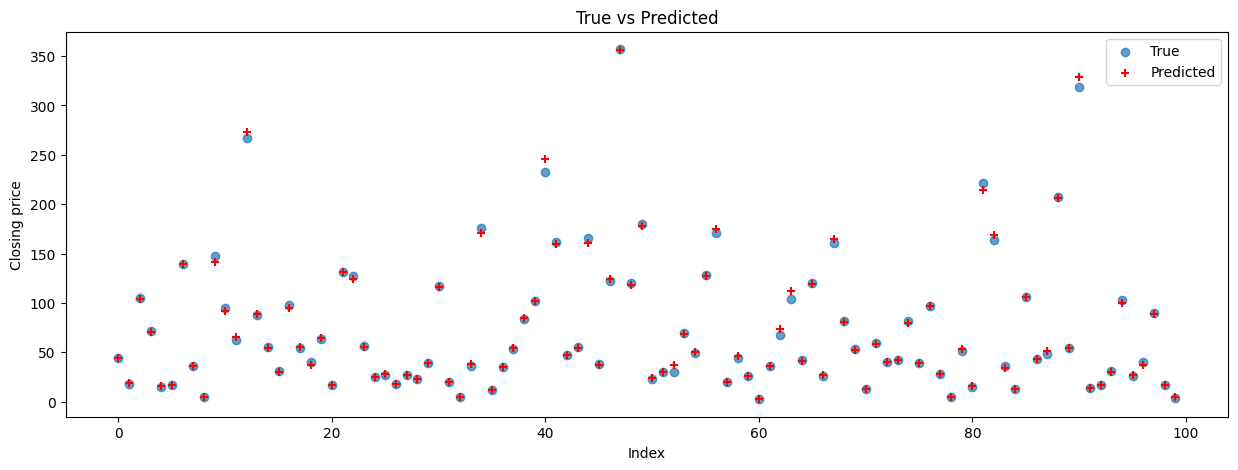

In [37]:
# Plot the true and predicted closing price
n = 100
rand_ids = np.random.randint(0, len(X_val), size=n)

plt.figure(figsize=(15, 5))
plt.scatter(x=range(n), y=y_test_stat.values[rand_ids], label="True", alpha=.7)
plt.scatter(x=range(n), y=y_pred_test[rand_ids], label="Predicted", alpha=1, marker="+", c="red")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()

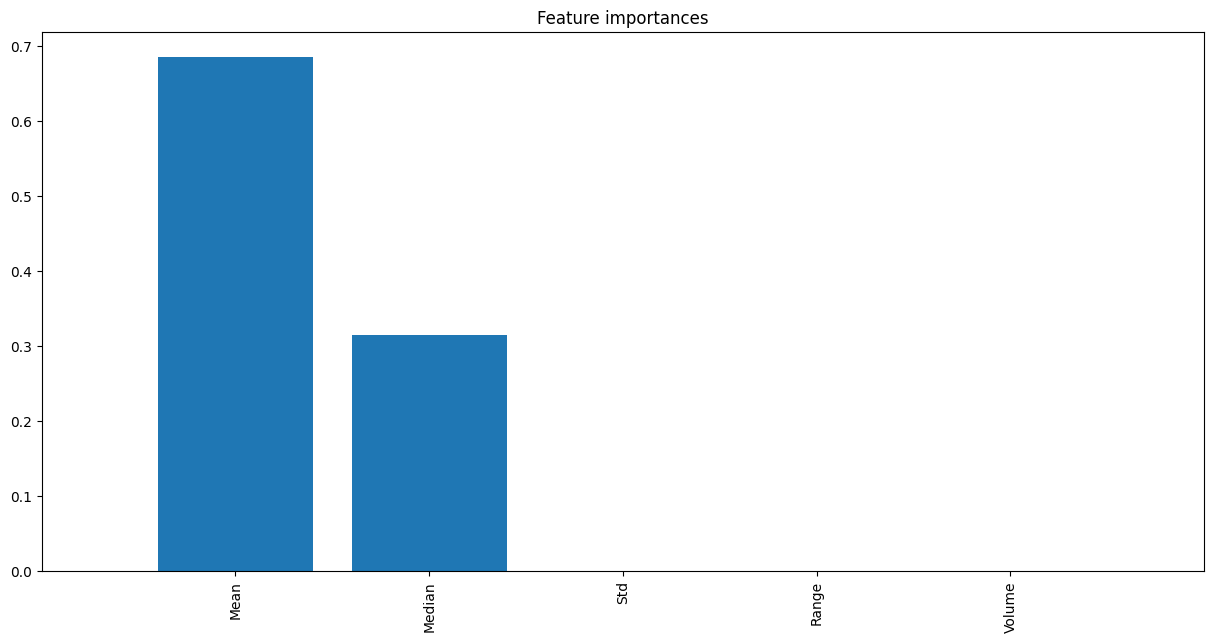

In [38]:
# Plot the feature importances
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(range(X_train_stat.shape[1]), importances[indices])
plt.xticks(range(X_train_stat.shape[1]), df_statistics.columns[indices], rotation=90)
plt.xlim([-1, X_train_stat.shape[1]])
plt.show()


## <ins>**IV. Conclusion**</ins>

### A. Summary of Results

In conclusion, we will train the model using the optimal parameters identified in the preceding section. Subsequently, we will evaluate its performance using the test set.

In [14]:
X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)

BEST_MODEL = RandomForestRegressor(max_depth=12, max_features=10, min_samples_leaf=2, n_estimators=12)
BEST_MODEL.fit(X_train, y_train)

y_pred = BEST_MODEL.predict(X_train)
y_pred_test = BEST_MODEL.predict(X_test)

print("Model Evaluation with Best Params")
print(f"MSE TRAIN: {mean_squared_error(y_train, y_pred):.4f}")
print(f"MSE TEST : {mean_squared_error(y_test, y_pred_test):.4f}\n")
print(f"MAE TRAIN: {mean_absolute_error(y_train, y_pred):.4f}")
print(f"MAE TEST : {mean_absolute_error(y_test, y_pred_test):.4f}\n")
print(f"R2  TRAIN: {r2_score(y_train, y_pred)}")
print(f"R2  TEST : {r2_score(y_test, y_pred_test)}")

Model Evaluation with Best Params
MSE TRAIN: 2.5497
MSE TEST : 7.0929

MAE TRAIN: 0.8083
MAE TEST : 1.3341

R2  TRAIN: 0.999552371437916
R2  TEST : 0.9987978129690482


As evident from the results, the model appears to be experiencing overfitting. To address this issue and improve our model, a potential solution is to augment the feature set by incorporating additional variables, such as weekly news data. This extension aims to enhance the model's capacity to capture and predict potential events that could impact stock prices. By including relevant external factors, we may improve the model's generalization and mitigate overfitting tendencies.

### B. Examples of Predictions with Recent Data (November 27, 2023)

In this final section, we will apply the model in a <i>'real-life'</i> scenario and predict the closing prices of the GAFAM companies on Friday for the week of November 27, 2023.

In [15]:
df_presentation = pd.read_csv("data_presentation/PresentationData.csv")

# Encode the company column
company = df_presentation[["Company"]]
company_encoded = encoder.transform(company).toarray()
df_company_encoded = pd.DataFrame(company_encoded, columns=encoder.get_feature_names_out())
df_presentation = pd.concat([df_presentation, df_company_encoded], axis=1)
df_presentation.drop(["Company"], axis=1, inplace=True)

# Select the features and the target
to_drop = [f for f in df_presentation.columns if f.startswith("Adj")] + [f for f in df_presentation.columns if f.endswith("_4")] + ["Date"]
X = df_presentation.drop(set(to_drop), axis=1)
y = df_presentation["Close_4"]

# Standardize the features
X = scaler_x.transform(X)

MSE: 15.8178
MAE: 3.0642


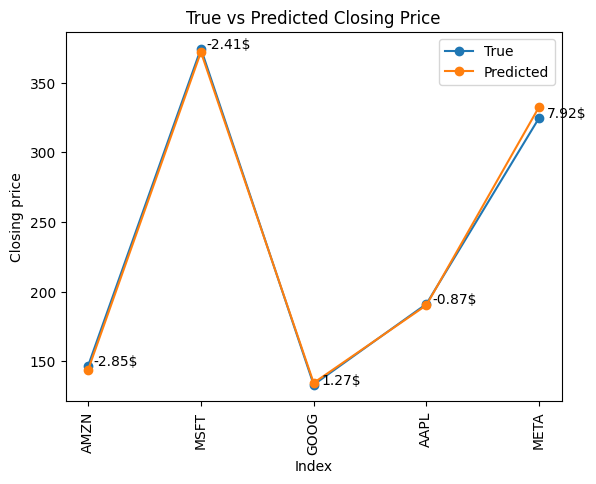

In [22]:
y_pred = BEST_MODEL.predict(X)

# Print the score of the model
print(f"MSE: {mean_squared_error(y, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y, y_pred):.4f}")

# Plot the true and predicted closing price using a line plot
plt.plot(y, label="True", marker='o')
plt.plot(y_pred, label="Predicted", marker='o')
plt.xticks(range(len(y)), company.T.values[0], rotation=90)

for i, (true_val, pred_val) in enumerate(zip(y, y_pred)):
    diff = pred_val - true_val
    plt.annotate(f"{diff:.2f}$", (i, true_val), textcoords="offset points", xytext=(20,0), ha='center')

plt.title("True vs Predicted Closing Price")
plt.xlabel("Company")
plt.ylabel("Closing price")
plt.legend()
plt.show()
